Crib sheet of the Hisaki data analysis for Venus

Written by Chizuru Nose 

In [34]:
# import library 
import matplotlib.pyplot as plt
import numpy as np
from datetime import timezone,datetime,timedelta
import sys
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors

# set path 
## Revise the path as nessesary for your environment
mypypath = '/Users/tsuch/VSCode/python/Hisaki/'
if mypypath not in sys.path:
    sys.path.append(mypypath)

## Revise the path as nessesary for your environment
hskpypath = '/Users/tsuch/VSCode/python/Hisaki/Hisaki_Py/'
if hskpypath not in sys.path:
    sys.path.append(hskpypath)


# import HisakiPy's library
import hskinit 
from hskpy.general.env import get_env
from hskpy.general.data import get_fname  ## Import get_fname function from data module
from hskpy.general.data import download_data_l2
from hskpy.general.data import plot_img, plot_xprof, plot_yprof ## import plotting functions from data module
from hskpy.general.data import HskData ## importing HskData class
from hskpy.general.data import ext_primary, ext_total, ext_offset # extensions of primary(=0), total(=1), and offset(=2)
from hskpy.general.time import Dt2str
from hskpy.general.calib import get_xbin_lim
from hskpy.external.horizons import HorizonsData


In [ ]:
# (1) download Hisaki Level-2 data from ISAS/DARTS
download_data_l2('venus', '20140309', mode='02')

File exeuv.venus.mod.02.20140309.lv.02.vr.00.fits exists in the local computer.


In [ ]:
# (2) getting file name and the list of file names 
fn = get_fname('venus', '20140309', mode='02')    ## Argments are target_body and date of data.
fn_lst = get_fname('venus','2014*' ,'02')

---- Opened exeuv.venus.mod.02.20140309.lv.02.vr.00.fits ----
---- Make sure that the fits data should be closed eventually. ----


EXTENSION=                                                                       [astropy.io.fits.card]
EXTENSION=                     / compiled at Apr 22 2015 09:35:11 (JST)          [astropy.io.fits.card]


Text(0.5, 1.0, 'venus\n2014-03-09 11:59:59 1day row')

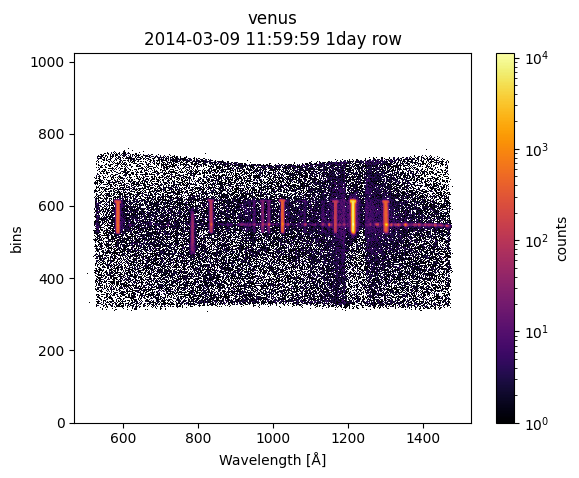

In [ ]:
# (3) getting caliblated wavelength data and plotting Level-2 raw data
hskdat = HskData(fn)
xcal, c2R, c2rtbl = hskdat.get_cal(daily=False)
img = hskdat.get_img(1)
mesh = plt.pcolormesh(xcal, np.arange(1024), img, cmap='inferno',norm=colors.LogNorm())
time = str(hskdat.get_timeDt(1))
plt.colorbar(mesh, label='counts')
plt.xlabel('Wavelength [Å]')
plt.ylabel('bins [pixel]')
title = hskdat.target_body +'\n' +  time + ' ' + '1day raw' 
plt.title(title)

Text(0.5, 1.0, 'venus\n2014-03-09 11:59:59 1day row')

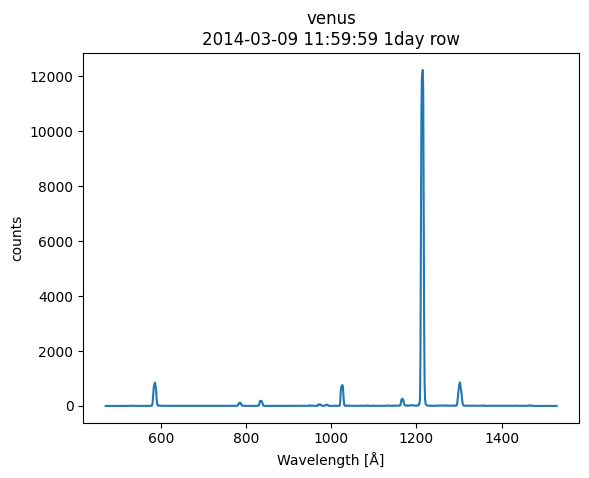

In [ ]:
# (3-2) plot spectra 
roi_y = [540,560]  # region of interest [pixel]
spectra = np.nansum(img[roi_y, : ], axis=0)
fig = plt.figure()
plt.plot(xcal, spectra)
#plt.xlim(480, 650) # set xrange (in wavelength)
#plt.ylim(-5000,20000)
plt.xlabel('Wavelength [Å]')
plt.ylabel('counts')
title = hskdat.target_body +'\n' +  time + ' ' + '1day raw' 
plt.title(title)

Text(0.5, 1.0, 'venus\n2014-03-09 11:59:59 1day row')

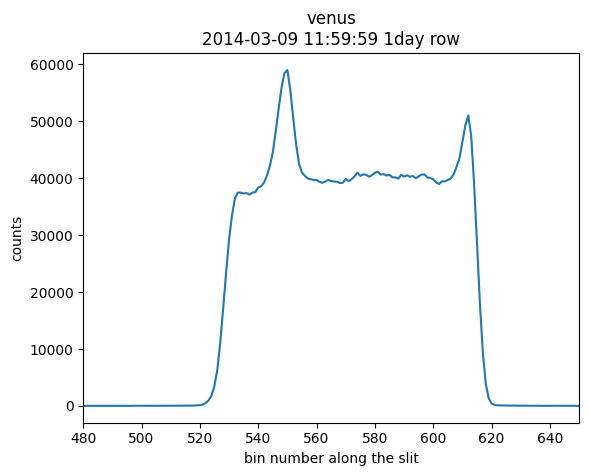

In [ ]:
# (3-3) plot spatial profile at HI Ly-a wavelength (1216 A)
idx_wv = np.where((xcal >= 1208) & (xcal <=1220))[0] ## Find indice of xcorresponding to 1208<wv<1220
yprof = np.nansum(img[:, idx_wv], axis=1)
fig = plt.figure()
plt.plot(np.arange(1024), yprof)
plt.xlim(480, 650) # set xrange (in wavelength)
#plt.ylim(-5000,20000)
plt.xlabel('bin number along the slit')
plt.ylabel('counts')
plt.title(title)

Subtracting sky geocorona

In [ ]:
# Data selection (Part 1)
def first_selection(hskdat,WR=[1208,1220]):
    #hskdat = HskData(fn)
    N = hskdat.get_nextend()
    
    #Check for continuous observations
    successive_lst = []
    for i in range(3,N-1):
        Dt1 = hskdat.get_timeDt(i-1)
        unx1 = Dt1.replace(tzinfo=timezone.utc).timestamp()
        Dt2 = hskdat.get_timeDt(i)
        unx2 = Dt2.replace(tzinfo=timezone.utc).timestamp()
        Dt3 = hskdat.get_timeDt(i+1)
        unx3 = Dt3.replace(tzinfo=timezone.utc).timestamp()
        if unx2 - unx1 <= 60 and unx3 -unx2 <= 60:
            successive_lst.append(i)

    #Centroid coordinates of the FOV camera
    bc1x = hskdat.get_header_value('BC1XAVE',fix=True)
    bc1y = hskdat.get_header_value('BC1YAVE',fix=True)
    bc2x = hskdat.get_header_value('BC2XAVE',fix=True)
    bc2y = hskdat.get_header_value('BC2YAVE',fix=True)
    bc_list = []
    for i in range(len(bc1x)):
        if bc1x[i] == 'nan' and bc1y[i] == 'nan' and bc2x[i] == 'nan' and bc2y[i] == 'nan':
            bc_list.append(int(i+2))
    Nextend_list = []
    for i in range(len(successive_lst)):
        for j in range(len(bc_list)):
            if successive_lst[i] == bc_list[j]:
                Nextend_list.append(successive_lst[i])
                break

    roi_x_bc = get_xbin_lim([700,900])
    roi_y_bc_1 =[700,1000]
    roi_y_bc_2 =[100,400]
    n_pix_bc1 = (roi_x_bc[1]-roi_x_bc[0])*(roi_y_bc_1[1]-roi_y_bc_1[0])
    n_pix_bc2 = (roi_x_bc[1]-roi_x_bc[0])*(roi_y_bc_2[1]-roi_y_bc_2[0])   
    select_list = []
    for i in Nextend_list:
        img = hskdat.get_img(i)
        c_bc1 =  np.sum(img[roi_y_bc_1[0]:roi_y_bc_1[1],roi_x_bc[0]:roi_x_bc[1]])/n_pix_bc1
        c_bc2 =  np.sum(img[roi_y_bc_2[0]:roi_y_bc_2[1],roi_x_bc[0]:roi_x_bc[1]])/n_pix_bc2
        if c_bc1 < 0.0026 and c_bc2 < 0.0026: 
            select_list.append(i)
    return select_list

In [ ]:
# Check observation flag
# Sky observation: offset 5 arcmin from the target
fs = first_selection(hskdat)
dis_list = []
ena_list=[]
for i in fs:  
    if hskdat.get_header_value('Calflg')[i] =='dis':# target
        dis_list.append(int(i))
    elif hskdat.get_header_value('Calflg')[i] =='ena':# sky
        ena_list.append(int(i))

sky_img = hskdat.get_img(ena_list)
sky_prof = np.nansum(sky_img[:, idx_wv], axis=1)/len(ena_list)
disk_img =hskdat.get_img(dis_list)
disk_prof = np.nansum(disk_img[:, idx_wv], axis=1)/len(dis_list)


 [astropy.io.fits.verify]


Text(0.5, 1.0, 'venus\n2014-03-09 11:59:59 1day row')

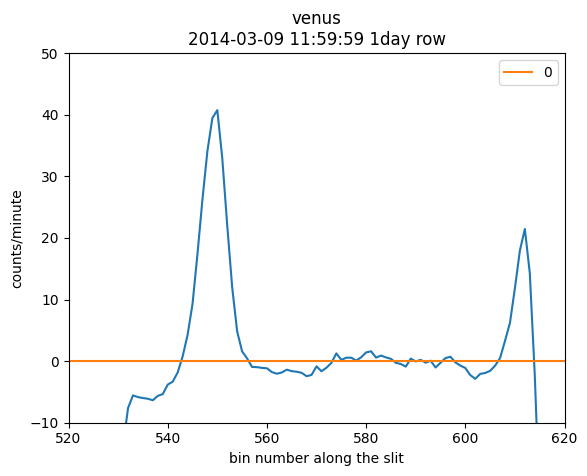

In [48]:
# Method (1)
# Assuming that pixels not containing the target at the same time are sky
roi_y_sky = [570,610]
sky = np.average(disk_prof[roi_y_sky[0]:roi_y_sky[1]]) 
sky_arr = np.full(1024,sky)
plt.plot(np.arange(1024), disk_prof-sky_arr)
plt.plot(np.arange(1024),np.zeros(1024),label='0')
plt.legend()
plt.xlim(520, 620) # set xrange (in wavelength)
plt.ylim(-10,50)
plt.xlabel('bin number along the slit')
plt.ylabel('counts/minute')
title = hskdat.target_body +'\n' +  time + ' ' + '1day row' 
plt.title(title)

Text(0.5, 1.0, 'venus\n2014-03-09 11:59:59 1day row')

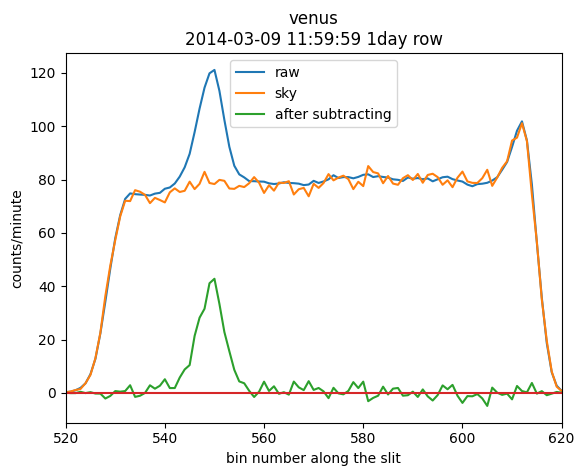

In [49]:
# Method (2)
# Using sky data to subtract the sky background for each corresponding pixel
f = sky /np.average(sky_prof[roi_y_sky[0]:roi_y_sky[1]]) 
plt.plot(np.arange(1024), disk_prof,label='raw')
plt.plot(np.arange(1024), sky_prof*f,label='sky')
plt.plot(np.arange(1024), disk_prof-sky_prof*f,label='after subtracting')
plt.plot(np.arange(1024),np.zeros(1024))
plt.legend()
plt.xlim(520, 620) # set xrange (in wavelength)
#plt.ylim(-10,40)
plt.xlabel('bin number along the slit')
plt.ylabel('counts/minute')
title = hskdat.target_body +'\n' +  time + ' ' + '1day row' 
plt.title(title)

In [44]:
st = hskdat.get_timeDt(1)
print(type(st))

<class 'datetime.datetime'>


In [45]:
from astroquery.jplhorizons import Horizons

st = hskdat.get_timeDt(1)
et = st + timedelta(days=1)

# Define the target (Venus:299) and observer (Earth:399)
obj = Horizons(id='299', location='500@399', epochs={'start':st.strftime('%Y-%m-%d'), 'stop':et.strftime('%Y-%m-%d'), 'step':'1d'})
# Get ephemeris data
data = obj.ephemerides()


In [46]:
##reading illumination area  data
#fname = "horizons_results.txt"
#hrz = HorizonsData(fname)
#def venus_illu(T):
#    
#    
#    dt = datetime(T.year,T.month,T.day)
#    illu = hrz.illu
#    Dt = hrz.timeDt
#    
#    for i in range(len(Dt)):
#        if dt == Dt[i]:
#           break
#    
#    return illu[i]


In [47]:
# calculating brightness from count
img_cal = disk_img/len(dis_list) - sky_img*f/len(ena_list)
roi_x  = get_xbin_lim([1208,1220])
st = hskdat.get_timeDt(1)
#illu = venus_illu(st)
illu = data['illumination'][0]
c_v = np.sum(img_cal[roi_y[0]:roi_y[1],roi_x[0]:roi_x[1]])
c2r_ave = np.mean(c2R[roi_x[0]:roi_x[1]])
d = hskdat.get_header_value('APPDIA', 2)
B_v= c_v*c2r_ave/np.pi/(d/2)**2*4.2*10*100/illu

print('Brightnes = ', B_v,'Rayleigh')

Brightnes =  75462.19752448774 Rayleigh
